# 1. Build Packman Environment with OpenAI Gym

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import cv2

import tensorflow as tf
from tensorflow import keras

In [2]:
class PackmanEnv(Env):
    rewards = {
        'Start': 50,
        0: -1,
        1: -2,
        2: -2,
        3: -2,
        4: -2,
        'CollectDirt': 2,  # (-2 + 2 = 0)
        'EndGame': 100
    }
    actions = {
        0: "Stay",
        1: "Left",
        2: "Up",
        3: "Right",
        4: "Down"
    }
    def __init__(self):
        # Actions we can take, left, down, stay, up, right
        self.action_space = Discrete(5)
        
        # Define a 2-D observation space
        self.observation_shape = (10, 10, 3)
        self.observation_space = Box(low=np.zeros(self.observation_shape),
                                            high=np.ones(self.observation_shape),
                                            dtype=np.float32)
        # Set start state
        self.dict_state = None
        self.canvas = None
        
        # Load human model from the computer
        self.human_model = tf.keras.models.load_model('./data/humanModel/mode_v0')
    
    
    
    def step(self, action):
        # Apply action
        # 0: "Stay"
        # 1: "Left"
        # 2: "Up"
        # 3: "Right"
        # 4: "Down"
        computer_reward = 0
        human_reward = 0
        
        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"
        
        human_pos = np.where(self.dict_state['Human trace'] == 1)
        computer_pos = np.where(self.dict_state['Computer trace'] == 1)
        # predict next human action
        
        # when human model is ready uncomment this line
#         human_action = self.predict_action(self.canvas)
        human_action = self.get_random_valid_action(human_pos)
    
        assert self.valid_action(action, computer_pos) , "Computer preformed invalid action: " + str(action) + " at pos: " + str(computer_pos)
        assert self.valid_action(human_action, human_pos) , "Human preformed invalid action: " + str(human_action) + " at pos: " + str(computer_pos)
    
        self.move(human_action, 'human') # assume human action is valid
        # apply the action to the agent
        self.move(action, 'computer')
        
        # check for clean dirt for both agents
        dirts_pos = np.where(self.dict_state['All awards'] == 1)
        for dirt_pos_i, dirt_pos_j in zip(dirts_pos[0], dirts_pos[1]):
            if human_pos[0][0] == dirt_pos_i and human_pos[1][0] == dirt_pos_j:
                self.dict_state['All awards'][human_pos] = 0
                self.dict_state['Human awards'][human_pos] = 1
                human_reward += self.rewards['CollectDirt']
            if computer_pos[0][0] == dirt_pos_i and computer_pos[1][0] == dirt_pos_j:
                self.dict_state['All awards'][computer_pos] = 0
                self.dict_state['Computer awards'][computer_pos] = 1
                computer_reward += self.rewards['CollectDirt']
                            
        # Reward for executing an action.
        computer_reward = self.rewards[action]
        human_reward = self.rewards[human_action]

        if not np.any(self.dict_state['All awards']): # game ended when there is no dirt to clean
            computer_reward += self.rewards['EndGame']
            human_reward += self.rewards['EndGame']
            done = True
        else:
            # Flag that marks the termination of an episode
            done = False
        
        self.ep_return += computer_reward
        self.ep_human_reward += human_reward
        
        self.canvas = self.convertToImage(self.dict_state)
        
        # Set placeholder for info
        info = {
                'done': done,
               'current_reward': computer_reward,
               'ep_return': self.ep_return,
               'human_return':self.ep_human_reward,
               }
        
        # Return step information
        return self.canvas, computer_reward, done, info

    def render(self, mode='human'):
        # Implement viz
        self.canvas = self.convertToImage(self.dict_state)
        # Render the environment to the screen
        if mode == 'human':
            if self.call_once:
                self.call_once = False
                plt.figure(figsize=(8,8))
                self.img = plt.imshow(self.canvas) # only call this once

            self.img.set_data(self.canvas) # just update the data
            plt.axis('off')
            info = {
               'ep_return': self.ep_return,
               'human_return':self.ep_human_reward,
            }
            plt.title(f'info: {info}')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        elif mode == 'rgb_array':
            return self.canvas
            
    def reset(self):
        self.call_once = True
        # Reset board game
        self.dict_state = self.init_state()
        self.canvas = self.convertToImage(self.dict_state)
        # Reset the reward
        self.ep_return = self.rewards['Start']
        self.ep_human_reward = self.rewards['Start']
        
        return self.canvas, self.ep_return
    
    
    #################### Helper functions ########################
    
    def init_state(self):
        # init board state with random n=5 dirt position
        board = np.array([
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
                    [0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
                    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                    [0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
                    [0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
                    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                    [0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
                    [0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                ])
        human_trace = np.zeros(board.shape)
        human_trace[2][2] = 1 # locate human player
        board[2][2] = 0 # locate human player
        
        computer_trace = np.zeros(board.shape)
        computer_trace[7][7] = 1 # locate computer player
        board[7][7] = 0 # locate computer player
        
        human_awards = np.zeros(board.shape)
        computer_awards = np.zeros(board.shape)

        all_awards = np.zeros(board.shape)
        idx = np.random.choice(np.count_nonzero(board), 5)
        all_awards[tuple(map(lambda x: x[idx], np.where(board)))] = 1
        board[2][2] = 1 # locate human player
        board[7][7] = 1 # locate computer player
        
        return {
                'Board': board,
                'Human trace': human_trace,
                'Computer trace': computer_trace,
                'Human awards': human_awards,
                'Computer awards': computer_awards,
                'All awards': all_awards,
                }
    
    def get_random_valid_action(self, pos):
        random_action = self.action_space.sample()
        while not self.valid_action(random_action, pos):
            random_action = self.action_space.sample()
        return random_action
    
    def valid_action(self, action, pos):
        next_pos = self.new_pos(pos, action)
        if self.dict_state['Board'][next_pos] == 0:
            return False
        else:
            return True

    def new_pos(self, current_pos, action):
            if action == 0: # stay
                return current_pos
            elif action == 1: # left
                return (current_pos[0], current_pos[1]-1)
            elif action == 2: # up
                return (current_pos[0]-1, current_pos[1])
            elif action == 3: # right
                return (current_pos[0], current_pos[1]+1)
            elif action == 4: # down
                return (current_pos[0]+1, current_pos[1])
            else: # default case if action is not found
                assert True , "action: " + str(action) + " is not vallid at agent pos: " + str(current_pos) + " for agent: " + str(agent) 
                
    def move(self, action, agent):
        # assume action is valid
        if agent == 'human':
            current_pos = np.where(self.dict_state['Human trace'] == 1)
            self.dict_state['Human trace'] = self.dict_state['Human trace']*0.9
            next_pos = self.new_pos(current_pos, action)
            self.dict_state['Human trace'][next_pos] = 1
        elif agent == 'computer':
            current_pos = np.where(self.dict_state['Computer trace'] == 1)
            self.dict_state['Computer trace'] = self.dict_state['Computer trace']*0.9
            next_pos = self.new_pos(current_pos, action) 
            self.dict_state['Computer trace'][next_pos] = 1
        else:
            assert True , "agent not define:" + str(agent)
    
    def predict_action(self, img):
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = self.human_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        
        action = np.argmax(score)
#         print(
#             "This image most likely belongs to {} with a {:.2f} percent confidence."
#             .format(action, 100 * np.max(score))
#         )
        return action

    def convertToImage(self, state):
        r = state['Human awards']/2 + state['Human trace']
        g = state['Board']/3 + state['All awards']
        b = state['Computer awards']/2 + state['Computer trace']
        rgb = np.dstack((r,g,b))
        return (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)) # NormalizeImage
    

In [3]:
env = PackmanEnv()

C:\Users\USER\Anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [8]:
import gym

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN

env = gym.make('CartPole-v1')

model = DQN(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=25000)
model.save("deepq_cartpole")

del model # remove to demonstrate saving and loading

model = DQN.load("deepq_cartpole")

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [7]:
from stable_baselines.common.env_checker import check_env

# It will check your custom environment and output additional warnings if needed
print(check_env(env))

2.6.0


C:\Users\USER\Anaconda3\lib\site-packages\stable_baselines\common\env_checker.py:25: UserWarning: It seems that your observation is an image but the `dtype` of your observation_space is not `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn("It seems that your observation is an image but the `dtype` "
C:\Users\USER\Anaconda3\lib\site-packages\stable_baselines\common\env_checker.py:31: UserWarning: It seems that your observation space is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn("It seems that your observation space is an image but the "
C:\Users\USER\Anaconda3\lib\site-packages\stable_baselines\common\env_checker.py:38: UserWarning: The minimal resolution for an image is 36x36 for the default CnnPolicy. You might need to use a custom `cnn_extractor

AssertionError: The observation returned by the `reset()` method should be a single value, not a tuple

Episode:2 =============> Score:-290


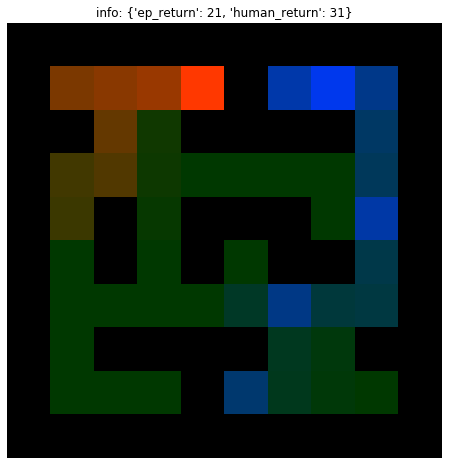

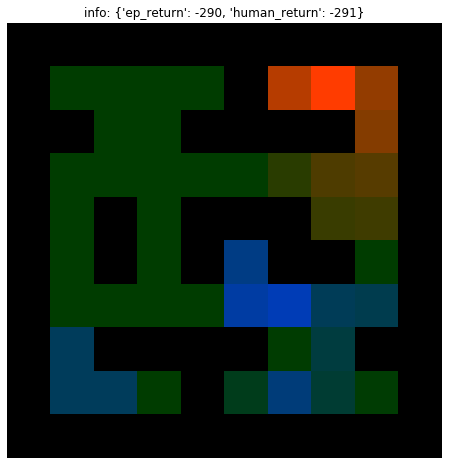

In [5]:
episodes = 2
for episode in range(1, episodes+1):
    state, score = env.reset()
    done = False
    
    while not done:

        computer_pos = np.where(env.dict_state['Computer trace'] == 1)
        action = env.get_random_valid_action(computer_pos)
        state, reward, done, info = env.step(action)
        
        env.render(mode='human')
        
        score += reward
#         print(info)
    print('Episode:{} =============> Score:{}'.format(episode, score))

# 2. Create a Deep Learning Model with Keras

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [5]:
states = env.observation_space.shape
actions = env.action_space.n

In [6]:
actions

5

In [7]:
states

(10, 10, 3)

In [8]:
def build_model(num_states, num_actions):
    model = Sequential()
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    model.add(Input(shape=(num_states)))
              
    model.add(Conv2D(filters=6, kernel_size=(3,3),input_shape=num_states, activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=2, strides=2))
              
    model.add(Conv2D(filters=4, kernel_size=(3,3),input_shape=num_states, activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(Flatten())
    model.add(Dense(num_actions, activation="softmax", kernel_initializer=last_init))

    return model

In [18]:
del model

In [19]:
model = build_model(states, actions)

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 10, 10, 6)         168       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 6)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 4)           220       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 473
Trainable params: 473
Non-trainable params: 0
________________________________________________________

# 3. Build Agent with Keras-RL

In [21]:
# import gym 
# env = gym.make('CartPole-v0')

In [22]:
# from rl.agents import DQNAgent
# from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
# from rl.memory import SequentialMemory

In [23]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [24]:
# def build_agent(model, actions):
#     policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=10000)
#     memory = SequentialMemory(limit=50000, window_length=1)
#     dqn = DQNAgent(model=model, memory=memory, policy=policy, 
#                   nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
#     return dqn

In [25]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [26]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)


ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (1, 1, 2)

In [30]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...


ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (1, 1, 2)

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

# 4. Reloading Agent from Memory

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)